In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import functools
import matplotlib.pyplot as plt
import numpy as np

from datasets.shapenet_data_pc import ShapeNet15kPointClouds
from models_adl4cv.pvcnn import PVCNNUp
from models_adl4cv.loss import get_repulsion_loss4

from metrics.ChamferDistancePytorch.chamfer_python import distChamfer

from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud

# Prepare Datasets and DataLoaders

In [4]:
tr_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["chair"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["chair"], split='val',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["chair"], split='test',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:4612
Min number of points: (train)2048 (test)2048
Total number of data:662
Min number of points: (train)2048 (test)2048
Total number of data:1317
Min number of points: (train)2048 (test)2048


In [5]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

In [6]:
len(tr_dataset), len(val_dataset), len(test_dataset)

(4612, 662, 1317)

# Let's see how the shapes change by adding this amount of noise

In [7]:
def add_random_noise(point_cloud, mean=0, std=0.05):
    noise = torch.normal(mean, std, size=point_cloud.size()).to("cuda")
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

# Let's train the PVCNN

In [8]:
def chamfer_distance(a, b):
    min_dist_a_to_b, min_dist_b_to_a, _, _ = distChamfer(a, b)
    return (min_dist_a_to_b.mean() + min_dist_b_to_a.mean()) / 2

In [9]:
def combined_loss(input, output):
    # Expects output of shape: [B, N, C]
    cd_loss = chamfer_distance(input, output)
    repulsion_loss = get_repulsion_loss4(output)
    return 100 * cd_loss + repulsion_loss

In [10]:
model = PVCNNUp(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")

In [11]:
noise = torch.normal(0, 1, size=(20, 3, 2048)).to("cuda")
output = model(noise)

noise.shape, output.shape

7
torch.Size([20, 3, 2048])
torch.Size([20, 64, 2048])
torch.Size([20, 128, 2048])
torch.Size([20, 128, 2048])
torch.Size([20, 512, 2048])
torch.Size([20, 2048, 2048])
torch.Size([20, 2048, 2048])
torch.Size([20, 4931, 2048])
torch.Size([20, 4931, 4096])


(torch.Size([20, 3, 2048]), torch.Size([20, 3, 4096]))

In [22]:
for batch in train_dataloader:
    input = batch["train_points"].to("cuda")

In [23]:
input.shape

torch.Size([20, 2048, 3])

In [ ]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PVCNN-Refinement-Patch-Chair'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

# Optimization
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

# Losses
training_losses = []
val_losses = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

In [30]:

for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0

    # Train
    model.train()
    for batch in train_dataloader:
        input = batch["train_points"].to("cuda")

        input_downsampled = input
        # Add noise to the input
        noised_downsampled_input = add_random_noise(input_downsampled)
        
        optimizer.zero_grad()
        output = model(noised_downsampled_input).to("cuda").transpose(1,2)
        
        loss = combined_loss(input, output)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)


    # Validate
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            input = batch["train_points"].to("cuda")

            input_downsampled = input
            # Add noise to the input
            noised_downsampled_input = add_random_noise(input_downsampled)
            output = model(noised_downsampled_input).to("cuda").transpose(1,2)
            
            val_loss = combined_loss(input, output)

            total_val_loss += val_loss.item()

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    print(f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # reset the patience counter
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    # Break the loop if patience exceeded
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    # Save the model
    model_save_path = f"output-models/pvcnn-refinement-patch-chair/PVCNN-Baseline-Refinement-Patch-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)


writer.close()

Epoch 1,  Training Loss: 0.0887, Validation Loss: 0.0274
Epoch 2,  Training Loss: 0.0215, Validation Loss: 0.0241
Epoch 3,  Training Loss: 0.0159, Validation Loss: 0.0172
Epoch 4,  Training Loss: 0.0131, Validation Loss: 0.0155
Epoch 5,  Training Loss: 0.0117, Validation Loss: 0.0149
Epoch 6,  Training Loss: 0.0105, Validation Loss: 0.0109
Epoch 7,  Training Loss: 0.0099, Validation Loss: 0.0074
Epoch 8,  Training Loss: 0.0092, Validation Loss: 0.0073
Epoch 9,  Training Loss: 0.0089, Validation Loss: 0.0054
Epoch 10,  Training Loss: 0.0085, Validation Loss: 0.0071
No improvement in validation loss for 1 epochs.
Epoch 11,  Training Loss: 0.0081, Validation Loss: 0.0052
Epoch 12,  Training Loss: 0.0077, Validation Loss: 0.0057
No improvement in validation loss for 1 epochs.
Epoch 13,  Training Loss: 0.0075, Validation Loss: 0.0051
Epoch 14,  Training Loss: 0.0073, Validation Loss: 0.0063
No improvement in validation loss for 1 epochs.
Epoch 15,  Training Loss: 0.0069, Validation Loss: 0.

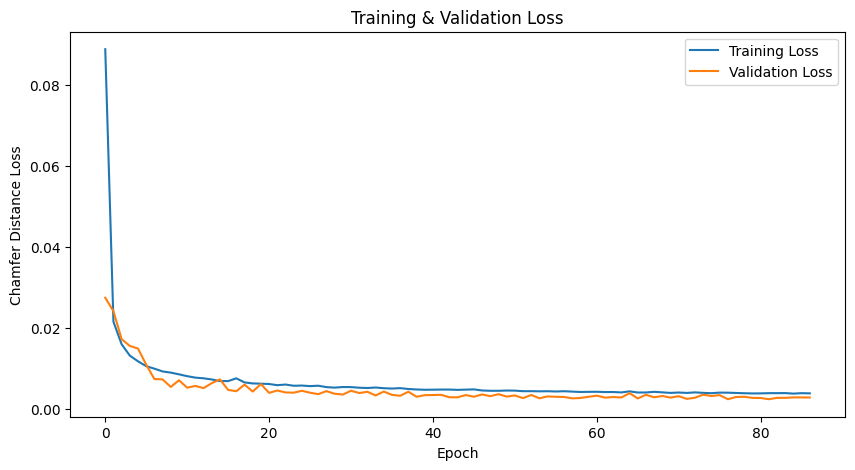

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Chamfer Distance Loss')
plt.legend()
plt.show()

# Let's visualize some examples

In [12]:
# Run this if you need to load the model.

model = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")
model.load_state_dict(torch.load("output-models/pvcnn-refinement-patch-chair/PVCNN-Baseline-Refinement-Patch-e76.pth"))

<All keys matched successfully>

# Evaluate the trained PVCNN

In [15]:
model.eval()

total_train_loss = 0

input_arr = []
output_arr = []

for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        input = batch["test_points"].to("cuda")
        patched_input = generate_non_overlapping_patches(input).transpose(2,3)
        
        # Add noise to the patched input
        noised_downsampled_input = add_random_noise(patched_input)

        denoised_patches = []
        for noised_patch in noised_downsampled_input:
            output = model(noised_patch).to("cuda")
            denoised_patches.append(output)

        output = torch.stack(denoised_patches).transpose(2,3).transpose(0,1).reshape(20, 2048, 3)
        
        input_arr.append(input)
        output_arr.append(output)

        loss = chamfer_distance(input, output)
        total_train_loss += loss.item()
        print(f"Batch {i}, CD Loss: {loss.item() * 10**3:.4f}")

average_loss = total_train_loss / len(test_dataloader)
print(f"TOTAL CD Loss: {average_loss * 10**3:.4f}")

Batch 0, CD Loss: 4.6770
Batch 1, CD Loss: 3.7639
Batch 2, CD Loss: 4.2869
Batch 3, CD Loss: 4.2829
Batch 4, CD Loss: 4.4961
Batch 5, CD Loss: 4.5633


Batch 6, CD Loss: 4.9317
Batch 7, CD Loss: 4.7745
Batch 8, CD Loss: 4.2918
Batch 9, CD Loss: 5.0072
Batch 10, CD Loss: 4.4840
Batch 11, CD Loss: 3.6124
Batch 12, CD Loss: 3.8543
Batch 13, CD Loss: 6.5580
Batch 14, CD Loss: 4.2280
Batch 15, CD Loss: 4.3563
Batch 16, CD Loss: 4.2022
Batch 17, CD Loss: 4.0425
Batch 18, CD Loss: 4.2971
Batch 19, CD Loss: 4.1871
Batch 20, CD Loss: 4.4401
Batch 21, CD Loss: 4.0053
Batch 22, CD Loss: 4.8686
Batch 23, CD Loss: 4.2159
Batch 24, CD Loss: 3.7911
Batch 25, CD Loss: 5.1275
Batch 26, CD Loss: 4.3255
Batch 27, CD Loss: 4.1068
Batch 28, CD Loss: 3.9701
Batch 29, CD Loss: 4.2437
Batch 30, CD Loss: 4.1461
Batch 31, CD Loss: 4.0907
Batch 32, CD Loss: 4.9711
Batch 33, CD Loss: 4.6258
Batch 34, CD Loss: 5.0943
Batch 35, CD Loss: 4.9687
Batch 36, CD Loss: 4.0152
Batch 37, CD Loss: 4.3449
Batch 38, CD Loss: 4.4876
Batch 39, CD Loss: 3.9384
Batch 40, CD Loss: 4.6204
Batch 41, CD Loss: 4.1612
Batch 42, CD Loss: 4.0122
Batch 43, CD Loss: 4.3954
Batch 44, CD Los

# Let's now try to imrpove the dataset of PVD

In [24]:
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=["chair"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

Total number of data:400
Min number of points: (train)2048 (test)2048


In [25]:
input_array = []

for batch in val_dataloader:
    input = batch["test_points"].to("cuda")
    input_array.append(input)

In [26]:
model.eval()

patch_array_input = []
patch_array_output = []
output_array = []
for batch in dataloader_pvd:
    with torch.no_grad():
        input = batch["test_points"].to("cuda")
        patched_input = generate_non_overlapping_patches(input).transpose(2,3)
        
        patch_array_input.append(patched_input.transpose(2,3).transpose(0,1))

        patch_list = []
        for patch in patched_input:
            output = model(patch).to("cuda")
            patch_list.append(output)

        patch_array_output.append(torch.stack(patch_list).transpose(2,3).transpose(0,1))
        output = torch.stack(patch_list).transpose(2,3).transpose(0,1).reshape(20, 2048, 3)

    output_array.append(output)

In [27]:
len(input_array), len(output_array)

(33, 20)

In [28]:
input_pcs = torch.stack(input_array[:20]).view(400, 2048, 3)
output_pcs = torch.stack(output_array).view(400, 2048, 3)
patch_output_pcs = torch.stack(patch_array_output).view(400, 4, 512, 3)
patch_input_pcs = torch.stack(patch_array_input).view(400, 4, 512, 3)
input_pcs.shape, output_pcs.shape, patch_output_pcs.shape, patch_input_pcs.shape

(torch.Size([400, 2048, 3]),
 torch.Size([400, 2048, 3]),
 torch.Size([400, 4, 512, 3]),
 torch.Size([400, 4, 512, 3]))

In [21]:
torch.save(input_pcs, "./eval-results/data-for-visualization/pvd-patch-refinement-input-pcs.pth")
torch.save(patch_input_pcs, "./eval-results/data-for-visualization/pvd-patch-refinement-input-patched-pcs.pth")

torch.save(output_pcs, "./eval-results/data-for-visualization/pvd-patch-refinement-output-pcs.pth")
torch.save(patch_output_pcs, "./eval-results/data-for-visualization/pvd-patch-refinement-output-patched-pcs.pth")

In [29]:
from metrics.evaluation_metrics import compute_all_metrics

results = compute_all_metrics(input_pcs, output_pcs, 100)
results = {k: (v.cpu().detach().item()
                if not isinstance(v, float) else v) for k, v in results.items()}

print(results)

100%|██████████| 400/400 [03:42<00:00,  1.80it/s]

{'lgan_mmd-CD': 0.09796344488859177, 'lgan_cov-CD': 0.5224999785423279, 'lgan_mmd_smp-CD': 0.110411636531353, 'lgan_mmd-EMD': 0.5672953128814697, 'lgan_cov-EMD': 0.5450000166893005, 'lgan_mmd_smp-EMD': 0.6092360615730286, '1-NN-CD-acc_t': 0.5575000047683716, '1-NN-CD-acc_f': 0.6075000166893005, '1-NN-CD-acc': 0.5824999809265137, '1-NN-EMD-acc_t': 0.5400000214576721, '1-NN-EMD-acc_f': 0.5849999785423279, '1-NN-EMD-acc': 0.5625}


In [ ]:
chair = {
    "lgan_mmd-CD": 0.09796344488859177,
    "lgan_cov-CD": 0.5224999785423279,
    "lgan_mmd_smp-CD": 0.110411636531353,
    "lgan_mmd-EMD": 0.5672953128814697,
    "lgan_cov-EMD": 0.5450000166893005,
    "lgan_mmd_smp-EMD": 0.6092360615730286,
    "1-NN-CD-acc_t": 0.5575000047683716,
    "1-NN-CD-acc_f": 0.6075000166893005,
    "1-NN-CD-acc": 0.5824999809265137,
    "1-NN-EMD-acc_t": 0.5400000214576721,
    "1-NN-EMD-acc_f": 0.5849999785423279,
    "1-NN-EMD-acc": 0.5625,
}

# NNA-CD: 58.25%
# NNA-EMD: 56.0%

In [ ]:
i = 1
for pvd_input, output_pvcnn in zip(input, output):
    input_np = pvd_input.squeeze().detach().cpu().numpy()
    output_np = output_pvcnn.squeeze().detach().cpu().numpy()
    
    fig = visualize_pointcloud_eval(input_np, output_np,"PVD Output", "PVCNN Refinement")
    # save_fig(fig, f"./eval-results/pvcnn-refinement/refined-pvd-output-{i}.jpg")

    i += 1

    if i > 5:
        break

In [ ]:
sample = 2

input_np = rotate_point_cloud_y(input[sample, :, :].squeeze().detach().cpu().numpy(), 45)
output_np = rotate_point_cloud_y(output[sample, :, :].squeeze().detach().cpu().numpy(), 45)

fig = visualize_pointcloud_eval(input_np, output_np,"PVD Output", "PVCNN Refinement")
# save_fig(fig, f"./eval-results/pvcnn-refinement/refined-pvd-output-{i}.jpg")

i = 0
for patch_input, patch_output in zip(patch_input_pcs[sample], patch_output_pcs[sample]):
    input_np = patch_input.squeeze().detach().cpu().numpy()
    output_np = patch_output.squeeze().detach().cpu().numpy()
    fig = visualize_pointcloud_eval(input_np, output_np, f"PVD Output Patch {i+1}", f"PVCNN Refinement Patch {i+1}")
    i+=1

In [50]:
sample = 2

input_np = input[sample, :, :].squeeze().detach().cpu().numpy()
output_np = output[sample, :, :].squeeze().detach().cpu().numpy()

In [51]:
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt

input_img = render_mitsuba(input_np, "./input.xml", fov=20)
output_img = render_mitsuba(output_np, "./output.xml", fov=20)

Center: [-0.0110774  -0.43631983 -0.5635861 ], Scale: 4.698935031890869
Center: [-0.01672757 -0.36071604 -0.5503076 ], Scale: 4.539949417114258


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


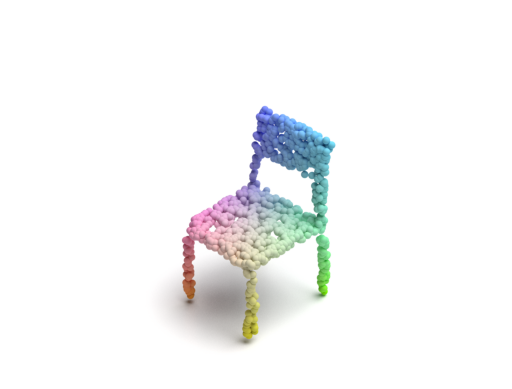

In [52]:
plt.axis("off")
plt.imshow(input_img ** (1.0 / 2.2)); # approximate sRGB tonemapping

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


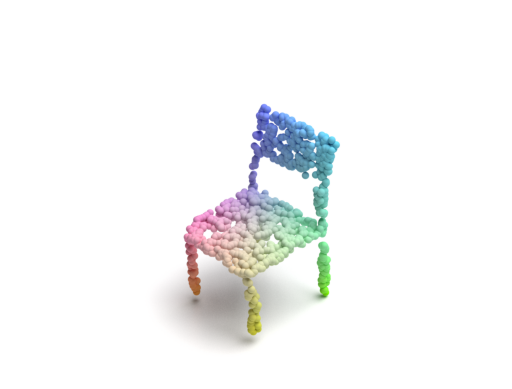

In [53]:
plt.axis("off")
plt.imshow(output_img ** (1.0 / 2.2)); # approximate sRGB tonemapping